In [60]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.algorithms import community

from langchain import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

os.environ["OPENAI_API_KEY"] = 'YOUR OPENAI API KEY'

In [2]:
# Load the txt file
txt_path = 'ukraine.txt'
with open(txt_path, 'r') as f:
  txt = f.read()

In [18]:
# Get segments from txt by splitting on .
segments =  txt.split('.')
# Put the . back in
segments = [segment + '.' for segment in segments]
# Further split by comma
segments = [segment.split(',') for segment in segments]
# Flatten
segments = [item for sublist in segments for item in sublist]

In [33]:
def create_sentences(segments, MIN_WORDS, MAX_WORDS):

  # Combine the non-sentences together
  sentences = []

  is_new_sentence = True
  sentence_length = 0
  sentence_num = 0
  sentence_segments = []

  for i in range(len(segments)):
    if is_new_sentence == True:
      is_new_sentence = False
    # Append the segment
    sentence_segments.append(segments[i])
    segment_words = segments[i].split(' ')
    sentence_length += len(segment_words)
    
    # If exceed MAX_WORDS, then stop at the end of the segment
    # Only consider it a sentence if the length is at least MIN_WORDS
    if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
      sentence = ' '.join(sentence_segments)
      sentences.append({
        'sentence_num': sentence_num,
        'text': sentence,
        'sentence_length': sentence_length
      })
      # Reset
      is_new_sentence = True
      sentence_length = 0
      sentence_segments = []
      sentence_num += 1

  return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

  sentences_df = pd.DataFrame(sentences)
  
  chunks = []
  for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
    chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
    chunk_text = ' '.join(chunk['text'].tolist())
    
    chunks.append({
      'start_sentence_num': chunk['sentence_num'].iloc[0],
      'end_sentence_num': chunk['sentence_num'].iloc[-1],
      'text': chunk_text,
      'num_words': len(chunk_text.split(' '))
    })
    
  chunks_df = pd.DataFrame(chunks)
  return chunks_df.to_dict('records')

def parse_title_summary_results(results):
  out = []
  for e in results:
    e = e.replace('\n', '')
    if '|' in e:
      processed = {'title': e.split('|')[0],
                    'summary': e.split('|')[1][1:]
                    }
    elif ':' in e:
      processed = {'title': e.split(':')[0],
                    'summary': e.split(':')[1][1:]
                    }
    elif '-' in e:
      processed = {'title': e.split('-')[0],
                    'summary': e.split('-')[1][1:]
                    }
    else:
      processed = {'title': '',
                    'summary': e
                    }
    out.append(processed)
  return out

In [26]:
sentences = create_sentences(segments, MIN_WORDS=20, MAX_WORDS=80)
chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

### Stage 1: Getting Chunk Summaries

In [37]:
def summarize_stage_1(chunks_text):
  
  print(f'Start time: {datetime.now()}')

  # Prompt to get title and summary for each chunk
  map_prompt_template = """Firstly, give the following text an informative title. Then, on a new line, write a 75-100 word summary of the following text:
  {text}

  Return your answer in the following format:
  Title | Summary...
  e.g. 
  Why Artificial Intelligence is Good | AI can make humans more productive by automating many repetitive processes.

  TITLE AND CONCISE SUMMARY:"""

  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

  # Define the LLMs
  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
  map_llm_chain_input = [{'text': t} for t in chunks_text]
  # Run the input through the LLM chain (works in parallel)
  map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

  stage_1_outputs = parse_title_summary_results([e['text'] for e in map_llm_chain_results])

  print(f'Stage 1 done time {datetime.now()}')

  return {
    'stage_1_outputs': stage_1_outputs
  }

In [38]:
# Run Stage 1 Summarizing
stage_1_outputs = summarize_stage_1(chunks_text)['stage_1_outputs']
# Split the titles and summaries
stage_1_summaries = [e['summary'] for e in stage_1_outputs]
stage_1_titles = [e['title'] for e in stage_1_outputs]
num_1_chunks = len(stage_1_summaries)

Start time: 2023-04-23 15:25:39.878620
Stage 1 done time 2023-04-23 15:25:53.392090


In [51]:
# Use OpenAI to embed the summaries and titles. Size of _embeds: (num_chunks x 1536)
openai_embed = OpenAIEmbeddings()

summary_embeds = np.array(openai_embed.embed_documents(stage_1_summaries))
title_embeds = np.array(openai_embed.embed_documents(stage_1_titles))

In [57]:
# Get similarity matrix between the embeddings of the chunk summaries
summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
summary_similarity_matrix[:] = np.nan

for row in range(num_1_chunks):
  for col in range(row, num_1_chunks):
    # Calculate cosine similarity between the two vectors
    similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
    summary_similarity_matrix[row, col] = similarity
    summary_similarity_matrix[col, row] = similarity

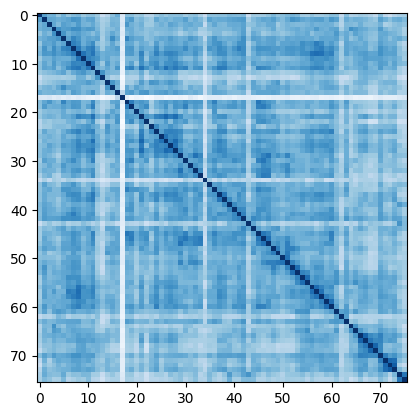

In [66]:
# Draw a heatmap with the summary_similarity_matrix
plt.figure()
# Color scheme blues
plt.imshow(summary_similarity_matrix, cmap = 'Blues')

In [132]:
# Run the community detection algorithm

def get_topics(title_similarity, num_topics = 8, bonus_constant = 0.25, min_size = 3):

  proximity_bonus_arr = np.zeros_like(title_similarity)
  for row in range(proximity_bonus_arr.shape[0]):
    for col in range(proximity_bonus_arr.shape[1]):
      if row == col:
        proximity_bonus_arr[row, col] = 0
      else:
        proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
  title_similarity += proximity_bonus_arr

  title_nx_graph = nx.from_numpy_array(title_similarity)

  desired_num_topics = num_topics
  # Store the accepted partitionings
  topics_title_accepted = []

  resolution = 0.85
  resolution_step = 0.01
  iterations = 40

  # Find the resolution that gives the desired number of topics
  topics_title = []
  while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    resolution += resolution_step
  topic_sizes = [len(c) for c in topics_title]
  sizes_sd = np.std(topic_sizes)
  modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

  lowest_sd_iteration = 0
  # Set lowest sd to inf
  lowest_sd = float('inf')

  for i in range(iterations):
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)
    
    # Check SD
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    
    topics_title_accepted.append(topics_title)
    
    if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
      lowest_sd_iteration = i
      lowest_sd = sizes_sd
      
  # Set the chosen partitioning to be the one with highest modularity
  topics_title = topics_title_accepted[lowest_sd_iteration]
  print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}')
  
  topic_id_means = [sum(e)/len(e) for e in topics_title]
  # Arrange title_topics in order of topic_id_means
  topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
  # Create an array denoting which topic each chunk belongs to
  chunk_topics = [None] * title_similarity.shape[0]
  for i, c in enumerate(topics_title):
    for j in c:
      chunk_topics[j] = i
            
  return {
    'chunk_topics': chunk_topics,
    'topics': topics_title
    }

In [133]:
# Set num_topics to be 1/4 of the number of chunks, or 8, which ever is smaller
num_topics = min(int(num_1_chunks / 4), 8)
topics_out = get_topics(summary_similarity_matrix, num_topics = num_topics, bonus_constant = 0.2)
chunk_topics = topics_out['chunk_topics']
topics = topics_out['topics']

Best SD: 1.019803902718557, Best iteration: 20
topics_title [[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22], [23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 36, 37, 30, 31], [38, 39, 40, 41, 42, 43, 44], [48, 49, 50, 51, 45, 46, 47], [52, 53, 54, 55, 56, 57, 58], [64, 65, 59, 60, 61, 62, 63], [66, 67, 68, 69, 70, 71, 72, 73, 74, 75]]
chunk topics [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


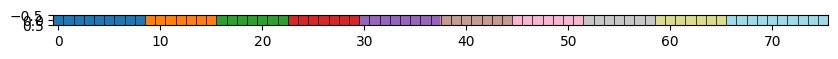

In [134]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis 
for i in range(1, len(chunk_topics)):
  plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

### Stage 2 Summaries

In [135]:
def summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250):
  print(f'Stage 2 start time {datetime.now()}')
  
  # Prompt that passes in all the titles of a topic, and asks for an overall title of the topic
  title_prompt_template = """Write an informative title that summarizes each of the following groups of titles. Make sure that the titles capture as much information as possible, 
  and are different from each other:
  {text}
  
  Return your answer in a numbered list, with new line separating each title: 
  1. Title 1
  2. Title 2
  3. Title 3

  TITLES:
  """

  map_prompt_template = """Wite a 75-100 word summary of the following text:
    {text}

    CONCISE SUMMARY:"""

  combine_prompt_template = 'Write a ' + str(summary_num_words) + """-word summary of the following, removing irrelevant information. Finish your answer:
  {text}
  """ + str(summary_num_words) + """-WORD SUMMARY:"""

  title_prompt = PromptTemplate(template=title_prompt_template, input_variables=["text"])
  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
  combine_prompt = PromptTemplate(template=combine_prompt_template, input_variables=["text"])

  topics_data = []
  for c in topics:
    topic_data = {
      'summaries': [stage_1_outputs[chunk_id]['summary'] for chunk_id in c],
      'titles': [stage_1_outputs[chunk_id]['title'] for chunk_id in c]
    }
    topic_data['summaries_concat'] = ' '.join(topic_data['summaries'])
    topic_data['titles_concat'] = ', '.join(topic_data['titles'])
    topics_data.append(topic_data)
    
  # Get a list of each community's summaries (concatenated)
  topics_summary_concat = [c['summaries_concat'] for c in topics_data]
  topics_titles_concat = [c['titles_concat'] for c in topics_data]

  # Concat into one long string to do the topic title creation
  topics_titles_concat_all = ''''''
  for i, c in enumerate(topics_titles_concat):
    topics_titles_concat_all += f'''{i+1}. {c}
    '''
  
  # print('topics_titles_concat_all', topics_titles_concat_all)

  title_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  title_llm_chain = LLMChain(llm = title_llm, prompt = title_prompt)
  title_llm_chain_input = [{'text': topics_titles_concat_all}]
  title_llm_chain_results = title_llm_chain.apply(title_llm_chain_input)
  
  
  # Split by new line
  titles = title_llm_chain_results[0]['text'].split('\n')
  # Remove any empty titles
  titles = [t for t in titles if t != '']
  # Remove spaces at start or end of each title
  titles = [t.strip() for t in titles]

  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  reduce_llm = OpenAI(temperature=0, model_name = 'text-davinci-003', max_tokens = -1)

  # Run the map-reduce chain
  docs = [Document(page_content=t) for t in topics_summary_concat]
  chain = load_summarize_chain(chain_type="map_reduce", map_prompt = map_prompt, combine_prompt = combine_prompt, return_intermediate_steps = True,
                              llm = map_llm, reduce_llm = reduce_llm)

  output = chain({"input_documents": docs}, return_only_outputs = True)
  summaries = output['intermediate_steps']
  stage_2_outputs = [{'title': t, 'summary': s} for t, s in zip(titles, summaries)]
  final_summary = output['output_text']

  # Return: stage_1_outputs (title and summary), stage_2_outputs (title and summary), final_summary, chunk_allocations
  out = {
    'stage_2_outputs': stage_2_outputs,
    'final_summary': final_summary
  }
  print(f'Stage 2 done time {datetime.now()}')
  
  return out

In [136]:
# Query GPT-3 to get a summarized title for each topic_data
out = summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250)
stage_2_outputs = out['stage_2_outputs']
stage_2_titles = [e['title'] for e in stage_2_outputs]
stage_2_summaries = [e['summary'] for e in stage_2_outputs]
final_summary = out['final_summary']

Stage 2 start time 2023-04-23 16:00:09.607349
titles 
  1. The Ukraine Conflict: One Year On and its Impact on Regional Security
  2. Putin's Rationality and Nuclear Weapons in War Zones
  3. Putin's Existential Threat in Crimea and its Consequences
  4. Putin's Potential Use of Nuclear Weapons in Ukraine
  5. War Aims and Ukraine's Position in the Conflict
  6. Biden Administration's Response to Potential Nuclear Conflict in Crimea
  7. Domestic Political Pressures in the Ukraine-Russia Conflict
  8. Western Public Opinion on the War in Ukraine and its Effects
  9. The Impact of Conflict on International Relations and Ukraine's War for Freedom
  10. Dysfunction in International Organizations and the Prospects of Ending the War
titles after process ['1. The Ukraine Conflict: One Year On and its Impact on Regional Security', "2. Putin's Rationality and Nuclear Weapons in War Zones", "3. Putin's Existential Threat in Crimea and its Consequences", "4. Putin's Potential Use of Nuclear Weap

In [138]:
final_summary

"\n\nThe 538 Politics Podcast will be hosting a live show in New York City on April 19th to discuss the one-year anniversary of Russia's full-scale invasion of Ukraine. The conflict has resulted in over 8,000 civilian deaths, 9,000 Ukrainian troop losses, and 40-60,000 Russian troop losses. Two experts on the conflict, Samuel Cherub and James Actin, will discuss the regional dynamics and nuclear risks associated with the Ukraine Crisis. US intelligence sharing with the Ukraine has been a major factor in the conflict, making it difficult for Russia to escalate without risking further conflict. Western military assistance has transformed Ukraine's ability to resist, making it less likely that Russia will be able to impose a pro-Russian government in Kiev. Putin has threatened to use nuclear weapons over newly annexed territories, but these threats have been a bluff. The US and NATO have refrained from direct involvement in the war, and the risk of a nuclear power plant accident is relati